<a href="https://colab.research.google.com/github/luckyman011/MarketingSegmentacion/blob/main/MarketingSegmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

Importamos la libreria Pandas para poder manipular los datos, Matplotlib para poder realizar los graficos necesarios, Numpy para realizar las operaciones matematicas y estadisticas y por ultimo la libreria Kmeans para realizar un aprendizaje no supervisado del analisis de datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Carga de DataSet

In [ ]:
data= pd.read_csv("/content/drive/MyDrive/marketing_campaign_data_socail_media.csv")
data

,Campaign_Type,Duration,Budget,Audience_Size,Audience_Age_Group,Engagement_Rate,Conversion_Rate
0,Instagram,45,95.802761,75579,35-44,7.775563,1.890406
1,YouTube,26,84.123524,88376,18-24,1.971576,4.269139
2,Instagram,50,91.688038,99427,25-34,5.504620,0.702806
3,YouTube,41,61.214077,40325,25-34,7.387365,2.035973
4,YouTube,40,74.356604,10775,18-24,4.336349,4.858624
...,...,...,...,...,...,...,...
9995,Facebook,20,45.421866,65743,35-44,1.906349,1.081577
9996,Snapchat,47,35.596357,26902,35-44,4.006777,4.098864
9997,Snapchat,20,38.556947,66015,45-54,5.907677,0.857623
9998,YouTube,10,16.310859,27539,18-24,5.988036,3.797551


El Dataset contiene 1000 filas y 7 columnas

#Objetivo

Descubrir en que campaña hay mayor cantidad de audiencia y reconozcer la edad de la audiencia con mayor tasa de participacion y de conversion.

Consideramos como datos relevantes a las campañas publicitarias con duracion de +14 dias y con +10.000 personas de audiencia.

#Exploracion

Reconocemos los tipos de datos que pertenecen a nuestro Dataset y sus caracteristicas.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Campaign_Type       10000 non-null  object 
 1   Duration            10000 non-null  int64  
 2   Budget              10000 non-null  float64
 3   Audience_Size       10000 non-null  int64  
 4   Audience_Age_Group  10000 non-null  object 
 5   Engagement_Rate     10000 non-null  float64
 6   Conversion_Rate     10000 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 547.0+ KB


##Analisis categorico de los datos

Realizamos un analisis categorico del Dataset para una mejor visualizacion de los valores

In [ ]:
categoricas = data.select_dtypes(include="object").columns
for columna in categoricas:
  print(f'Tabla de frecuencia para "{columna}":')
  frecuencia = data[columna].value_counts().reset_index()
  frecuencia.columns = [columna, "Frecuencia"]
  display(frecuencia)
  print("\n")

Tabla de frecuencia para "Campaign_Type":


,Campaign_Type,Frecuencia
0,Snapchat,2039
1,Instagram,2029
2,YouTube,2027
3,Facebook,1966
4,TikTok,1939




Tabla de frecuencia para "Audience_Age_Group":


,Audience_Age_Group,Frecuencia
0,45-54,2100
1,18-24,1996
2,25-34,1993
3,35-44,1958
4,55-64,1953


#Limpieza de los datos
Realizamos un renombre de las columnas del ingles al español para un entendimiento mas sencillo de los datos, eliminamos los valores y columnas irrelevantes para la investigacion.

##Renombre de columnas

In [ ]:
data = data.rename(columns={'Campaign_Type':'Campaña','Duration': 'Duracion','Budget': 'Presupuesto','Audience_Size':'Audiencia','Audience_Age_Group':'Edad_Audiencia','Engagement_Rate':'Tasa_Participacion','Conversion_Rate':'Tasa_Conversion',
})
data.head()

,Campaña,Duracion,Presupuesto,Audiencia,Edad_Audiencia,Tasa_participacion,Tasa_conversion,Clientes
0,Instagram,45,95.802761,75579,35-44,7.775563,1.890406,1428.750003
1,YouTube,26,84.123524,88376,18-24,1.971576,4.269139,3772.893931
2,Instagram,50,91.688038,99427,25-34,5.504620,0.702806,698.779350
3,YouTube,41,61.214077,40325,25-34,7.387365,2.035973,821.006224
4,YouTube,40,74.356604,10775,18-24,4.336349,4.858624,523.516778


##Eliminacion de datos irrelevantes

Ponemos como filtro los valores de la columna "Duracion" >= a 14 dias y los valores de la columna "Audiencia" >= a 10000 personas de la audiencia.

In [ ]:
data = data[data['Duracion'] >= 14]

In [ ]:
data = data[data['Audiencia'] >= 10000]

##Cantidad de filas y columnas postlimpieza

In [ ]:
data.shape

(7138, 7)

#Analisis

##Cantidad de audiencia total en cada campaña

Agrupamos por campaña la sumatoria de audiencia del DataFrame.

In [ ]:
audiencia_por_campaña = data.groupby('Campaña')['Audiencia'].sum().sort_values(ascending=False)
audiencia_por_campaña

,Audiencia
Campaña,
YouTube,80570938
Facebook,80544961
Instagram,79598541
Snapchat,79189080
TikTok,73769906


Podemos ver en la tabla que "Instagram" es la campaña con mayor Audiencia con una diferencia de 28.319 de "Youtube". Posteriormente, las demas campañas tiene una leve diferenciacion de 1.000.000 personas alcanzadas.

##Cantidad de audiencia total por rango de edad

En el siguiente grafico muestra por segmentos, donde yace mayor cantidad de personas por margen de edad de forma descendiente.

In [ ]:
# Segmentar Edad_audiencia por Audiencia
audiencia_edad = data.groupby(['Edad_Audiencia'])['Audiencia'].sum().sort_values(ascending=False)
audiencia_edad

,Audiencia
Edad_Audiencia,
45-54,81914416
25-34,80825010
55-64,77707970
18-24,77048797
35-44,76177233


Podemos observar que la audiencia de 45-54 años es la de mayor volumen con una diferencia de 1.089.406 ante el segundo grupo, la audiencia de 25-34 años. Posteriormente, entre el segundo y tercero grupo podemos ver una diferencia de 3.117.040 en audiencia. Los demas grupos varian aproximadamente 1.000.000 en numeros de audiencia.

##Cantidad de Clientes por campaña

In [ ]:
data['Clientes'] = data['Tasa_conversion'] * data['Audiencia'] / 100
data[['Campaña', 'Clientes']].sort_values(by='Clientes', ascending=False)

,Campaña,Clientes
4420,Instagram,4989.082880
8220,Instagram,4872.770735
7687,YouTube,4849.049791
9555,Facebook,4792.308053
548,YouTube,4782.031971
...,...,...
2588,Instagram,21.387740
6605,Instagram,17.011821
6542,TikTok,16.083456
5551,Snapchat,15.998280


Podemos observar que la mayor cantidad de clientes obtenidos en una publicidad fue 4989 en la campaña de Instagram, la segunda campaña con 4849 fue Youtube y tercero con 4792, Facebook.

##Total de clientes
Calculamos la cantidad total de clientes por cada tipo de campaña

In [ ]:
# Calcular la cantidad total de clientes por campaña
total_clientes = data.groupby("Campaña")["Clientes"].sum().sort_values(ascending=False)
# Ajustar la visualización para mostrar todos los números completos
pd.set_option('display.float_format', '{:.0f}'.format)
# Mostrar el resultado
total_clientes

,Clientes
Campaña,
YouTube,2051110
Facebook,2046791
Snapchat,2007324
Instagram,1996263
TikTok,1880253


#Visualizacion de los datos en graficos

Realizamos graficos sobre los datos ya analizados

##Correlacion de los datos
Podemos observar que no hay ninguna correlacion entre los datos

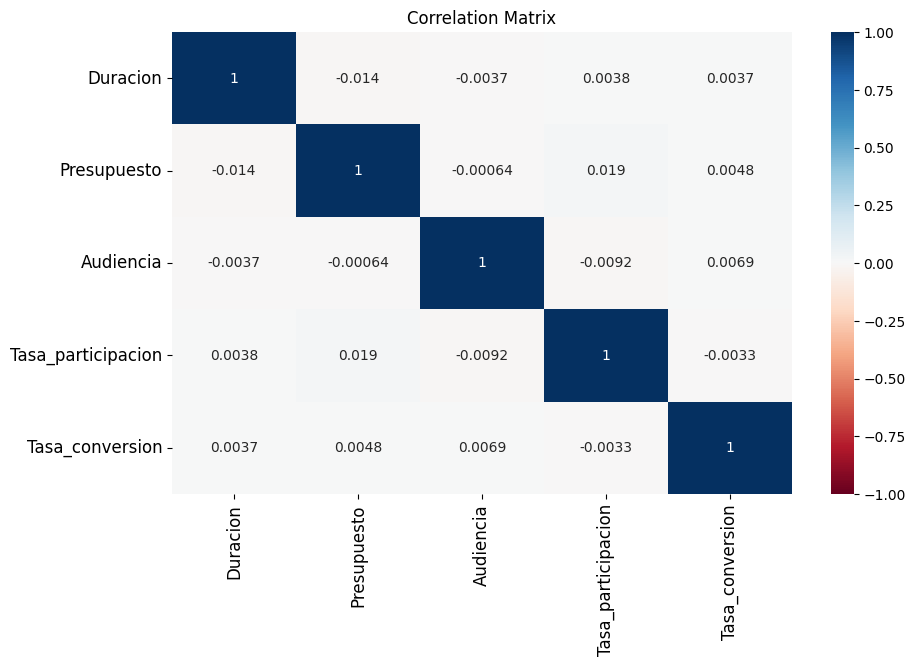

In [ ]:
numerical_data = data.select_dtypes(include=np.number)
plt.figure(figsize=(10, 6))
correlation_matrix = numerical_data.corr()
s = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin = -1, vmax= 1)
s.set_xticklabels(s.get_xticklabels(), rotation=90, fontsize = 12)
s.set_yticklabels(s.get_yticklabels(), rotation=0, fontsize = 12)
plt.title('Correlation Matrix')
plt.show()

##Grafico de Audiencia por campaña
Graficamos los datos del data series "audiencia_por_campaña" realizado anteriormente.


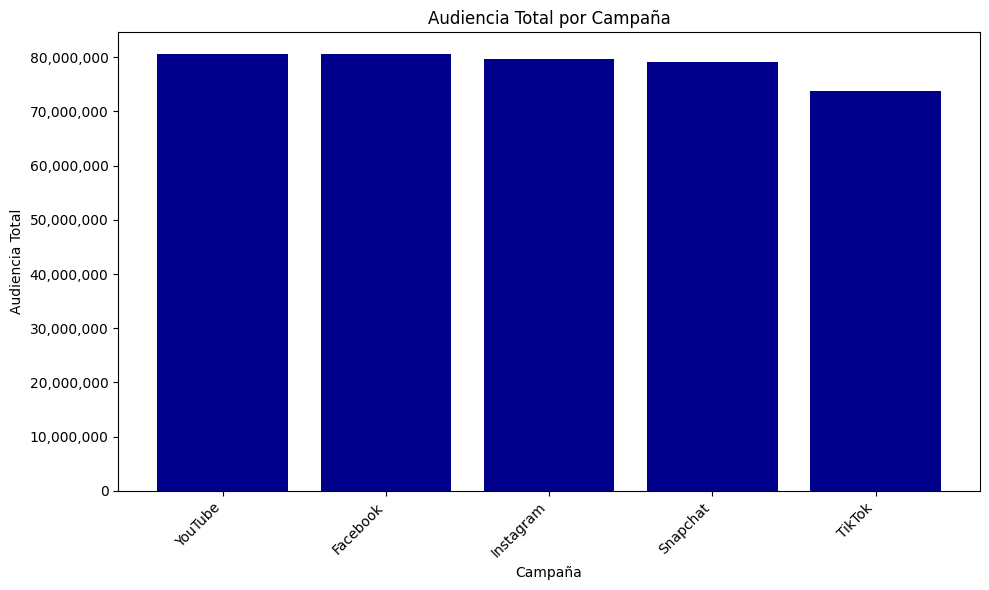

In [ ]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
# Define a function to format the y-axis labels (e.g., to add commas)
def format_y_axis(x, pos):
    return '{:,.0f}'.format(x) # Format with commas for thousands separator

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis)) # Pass the function to FuncFormatter
# Sort the data before plotting to display bars in descending order
audiencia_por_campaña_sorted = audiencia_por_campaña.sort_values(ascending=False)
plt.bar(audiencia_por_campaña_sorted.index, audiencia_por_campaña_sorted.values, color='darkblue') #Plot the sorted data
# Configurar etiquetas y título
plt.xlabel('Campaña')
plt.ylabel('Audiencia Total')
plt.title('Audiencia Total por Campaña')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

Observamos que la campaña de Youtube es la de mayor audiencia por una diferencia diminuta de las demas campañas, a excepcion de Tiktok.

##Grafico de Cantidad de Clientes por campaña

Graficamos la tasa de conversion obtenida en promedio de cada campaña

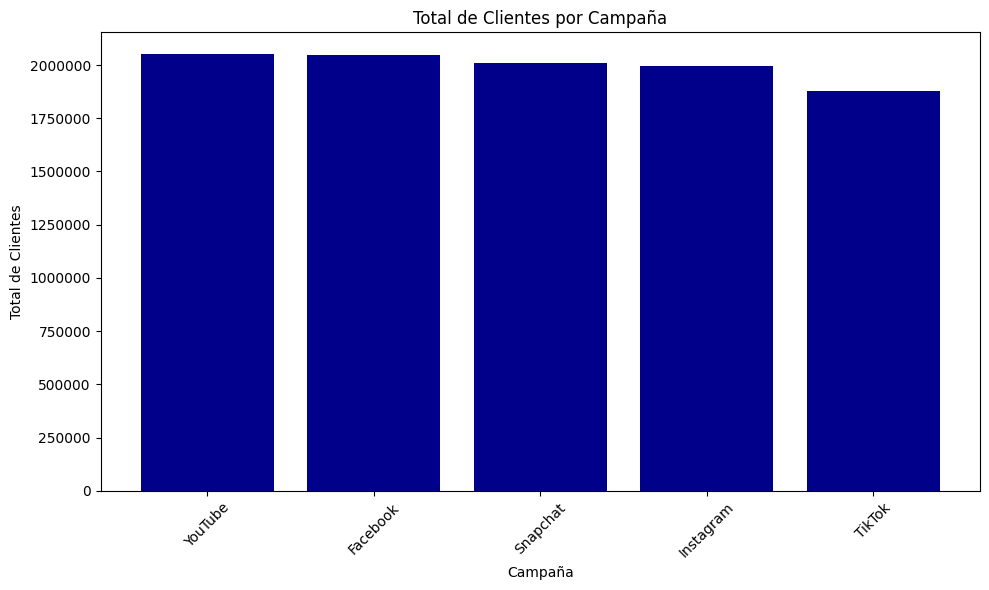

In [ ]:
# Ordenar los valores de mayor a menor
total_clientes = total_clientes.sort_values(ascending=False)
# Ajustar la visualización de los números a enteros completos
pd.set_option('display.float_format', '{:.0f}'.format)

# Graficar el total de clientes por campaña
plt.figure(figsize=(10, 6))
plt.bar(total_clientes.index, total_clientes.values, color='darkblue')

# Ajustar el formato de los números en el eje Y para evitar notación científica
plt.ticklabel_format(style='plain', axis='y')  # Esto desactiva la notación científica

# Etiquetas y título
plt.xlabel('Campaña')
plt.ylabel('Total de Clientes')
plt.title('Total de Clientes por Campaña')

# Mostrar la gráfica
plt.xticks(rotation=45)  # Rotar para mejor visibilidad
plt.tight_layout()  # Ajustar el espacio de la gráfica
plt.show()

Podemos observar que Youtube es la campaña con mayor cantidad de clientes obtenidos por una leve diferencia contra las campañas de Facebook, Snapchat e Instagram.

##Preprocesamiento de los datos

In [ ]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
data_numerical = data[numerical_features]
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data_numerical)

##Grafico Clustering

Utilizamos la funcion Kmeans para analizar la inercia de los datos en cantidad de clusters

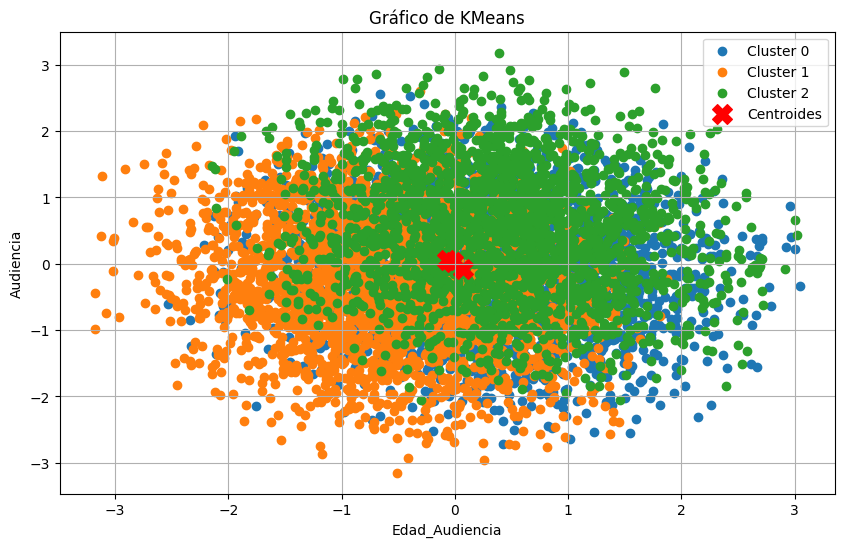

In [ ]:
# Seleccionar columnas numéricas y codificar las categóricas
data_encoded = data.copy()
le = LabelEncoder()
data_encoded['Campaña'] = le.fit_transform(data['Campaña'])
data_encoded['Edad_Audiencia'] = le.fit_transform(data['Edad_Audiencia'])

# Seleccionar características relevantes para clustering
features = ['Duracion', 'Presupuesto', 'Audiencia', 'Tasa_participacion', 'Tasa_conversion', 'Campaña', 'Edad_Audiencia']
X = data_encoded[features]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Realizar clustering con KMeans (n=3 clusters como ejemplo)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Reducir dimensiones para visualización (PCA a 2 componentes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar los clusters
plt.figure(figsize=(10, 6))
for cluster in range(3):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f'Cluster {cluster}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')

plt.title('Gráfico de KMeans')
plt.xlabel('Edad_Audiencia')
plt.ylabel('Audiencia')
plt.legend()
plt.grid()
plt.show()

Hicimos un grafico con un numero de 3 clusters, uno para cada campaña. Asignamos las leyendas y consideramos todos los datos que componen al Dataset.Podemos analizar una gran cantidad de datos que se superponen entre sí, es decir, los clusters no tienen diferencias marcadas.

#Conclusion
Podemos concluir que en la mayoria de los casos Youtube fue la campaña con los valores mas altos en las variables del DataSet, pero por una diferencia casi distingible ante las demas campañas. Esto quiere decir que los datos son muy constantes, por lo tanto, recomendariamos utilizar una muestra de datos mayor o con variables mas especificas para un analisis mas eficiente de los resultados estimados.